In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.read_csv('hunhe.csv').tail()

lh   rh    ls     rs    w   ll   rl       0x       0y       1x  ...  \
2014  277  385  3739  10760  281  450    0  1001.15  206.476  1001.34  ...   
2015  271  379  4758  10749  278  450    0  1001.38  206.527  1004.23  ...   
2016  272  374  3355  10576  275  451  296  1007.14  206.501  1010.03  ...   
2017  293  369  2504  10626  271  450  293  1015.89  206.611  1015.94  ...   
2018  354  390  3903  11134  269  449  283  1018.91  206.603  1021.73  ...   

          20x      20y      21x      21y      22x      22y      23x      23y  \
2014  1095.48  1009.99  1045.32  974.767  880.482  1004.25  862.934  995.372   
2015  1098.33  1009.98  1045.32  974.749  880.486  1004.20  862.929  995.324   
2016  1095.52  1010.00  1045.39  974.591  880.498  1007.09  862.904  998.166   
2017  1095.50  1010.06  1045.32  974.597  880.459  1007.04  862.891  998.167   
2018  1095.49  1007.09  1045.44  974.646  880.552  1004.18  865.778  995.352   

          24x      24y  
2014  924.668  968.779  
2015  924.709  965.913  
2016  924.714  962.921  
2017  924.710  962.914  
2018  924.733  959.973  

[5 rows x 57 columns]

In [3]:
train_x = []

# Store csv file in a Pandas DataFrame
df = pd.read_csv('hunhe.csv')

# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
data = sc.fit_transform(df.values)

# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
label_sc.fit(df.iloc[:,7:57].values)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [4]:
# Define lookback period and split inputs/labels
lookback = 10
inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
labels = np.zeros((len(data)-lookback, 50))
print(inputs.shape)
print(labels.shape)
for i in range(lookback, len(data)):
    inputs[i-lookback] = data[i-lookback:i]
    labels[i-lookback] = data[i][7:57]
inputs = inputs.reshape(-1,lookback,df.shape[1])
labels = labels.reshape(-1, 50)
print(inputs.shape)
print(labels.shape)

(2009, 10, 57)
(2009, 50)
(2009, 10, 57)
(2009, 50)


In [5]:
# Split data into train/test portions and combining all data from different files into a single array
test_portion = int(0.1*len(inputs))
train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]
test_x = inputs[-test_portion:]
test_y = labels[-test_portion:]
print(test_y)
labs = torch.from_numpy(np.array(test_y))
label_sc.inverse_transform(labs)

[[0.94458961 0.39383953 0.34135787 ... 0.95729934 0.6791661  0.94783057]
 [0.96671037 0.42727356 0.60614966 ... 0.93671591 0.03897868 0.96485915]
 [0.94449528 0.38845599 0.28887435 ... 0.95802283 0.67908461 0.94793601]
 ...
 [0.95005141 0.3938033  0.4997133  ... 0.97862796 0.19993209 0.93060868]
 [0.95830543 0.39401307 0.5526627  ... 0.9786352  0.19987777 0.93056768]
 [0.96115424 0.39399782 0.60453698 ... 0.95826882 0.20019014 0.91333993]]


array([[1001.35 ,  206.52 ,  992.355, ...,  995.218,  960.   ,  965.861],
       [1024.8  ,  224.052, 1021.91 , ...,  992.373,  912.863,  968.768],
       [1001.25 ,  203.697,  986.497, ...,  995.318,  959.994,  965.879],
       ...,
       [1007.14 ,  206.501, 1010.03 , ...,  998.166,  924.714,  962.921],
       [1015.89 ,  206.611, 1015.94 , ...,  998.167,  924.71 ,  962.914],
       [1018.91 ,  206.603, 1021.73 , ...,  995.352,  924.733,  959.973]])

In [6]:
print(test_y)

[[0.94458961 0.39383953 0.34135787 ... 0.95729934 0.6791661  0.94783057]
 [0.96671037 0.42727356 0.60614966 ... 0.93671591 0.03897868 0.96485915]
 [0.94449528 0.38845599 0.28887435 ... 0.95802283 0.67908461 0.94793601]
 ...
 [0.95005141 0.3938033  0.4997133  ... 0.97862796 0.19993209 0.93060868]
 [0.95830543 0.39401307 0.5526627  ... 0.9786352  0.19987777 0.93056768]
 [0.96115424 0.39399782 0.60453698 ... 0.95826882 0.20019014 0.91333993]]


In [7]:
batch_size = 10

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
input_dim = next(iter(train_loader))[0].shape
print(input_dim)

torch.Size([10, 10, 57])


In [8]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [9]:
print(device)

cpu


In [10]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [11]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 50
    n_layers = 2
    # Instantiating the model
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            #if counter%20 == 0:
            print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


In [12]:
def evaluate(model, test_x, test_y, label_sc):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    
    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))
    
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [13]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 1/180....... Average Loss for Epoch: 0.4875738024711609
Epoch 1......Step: 2/180....... Average Loss for Epoch: 0.45682136714458466
Epoch 1......Step: 3/180....... Average Loss for Epoch: 0.40807873010635376
Epoch 1......Step: 4/180....... Average Loss for Epoch: 0.35683638975024223
Epoch 1......Step: 5/180....... Average Loss for Epoch: 0.3104634314775467
Epoch 1......Step: 6/180....... Average Loss for Epoch: 0.2716924461225669
Epoch 1......Step: 7/180....... Average Loss for Epoch: 0.2442912267787116
Epoch 1......Step: 8/180....... Average Loss for Epoch: 0.2201087884604931
Epoch 1......Step: 9/180....... Average Loss for Epoch: 0.2009497404926353
Epoch 1......Step: 10/180....... Average Loss for Epoch: 0.1849325980991125
Epoch 1......Step: 11/180....... Average Loss for Epoch: 0.17361885783347217
Epoch 1......Step: 12/180....... Average Loss for Epoch: 0.16344122868031263
Epoch 1......Step: 13/180....... Average Loss for Epoch: 0.15

Epoch 1......Step: 114/180....... Average Loss for Epoch: 0.03605271122630751
Epoch 1......Step: 115/180....... Average Loss for Epoch: 0.035943138761364894
Epoch 1......Step: 116/180....... Average Loss for Epoch: 0.0358385001309216
Epoch 1......Step: 117/180....... Average Loss for Epoch: 0.035696064336941793
Epoch 1......Step: 118/180....... Average Loss for Epoch: 0.035459644449243356
Epoch 1......Step: 119/180....... Average Loss for Epoch: 0.0352897456643649
Epoch 1......Step: 120/180....... Average Loss for Epoch: 0.03510910215554759
Epoch 1......Step: 121/180....... Average Loss for Epoch: 0.03494611356699885
Epoch 1......Step: 122/180....... Average Loss for Epoch: 0.03478348126528082
Epoch 1......Step: 123/180....... Average Loss for Epoch: 0.03463460989220719
Epoch 1......Step: 124/180....... Average Loss for Epoch: 0.03449091245795811
Epoch 1......Step: 125/180....... Average Loss for Epoch: 0.03435518443211913
Epoch 1......Step: 126/180....... Average Loss for Epoch: 0.034

Epoch 2......Step: 41/180....... Average Loss for Epoch: 0.010720960103066229
Epoch 2......Step: 42/180....... Average Loss for Epoch: 0.010635175708947437
Epoch 2......Step: 43/180....... Average Loss for Epoch: 0.010646391865732364
Epoch 2......Step: 44/180....... Average Loss for Epoch: 0.010633908878927205
Epoch 2......Step: 45/180....... Average Loss for Epoch: 0.01059594883893927
Epoch 2......Step: 46/180....... Average Loss for Epoch: 0.010515264903559633
Epoch 2......Step: 47/180....... Average Loss for Epoch: 0.010768332122329702
Epoch 2......Step: 48/180....... Average Loss for Epoch: 0.01070194622540536
Epoch 2......Step: 49/180....... Average Loss for Epoch: 0.010672162334453695
Epoch 2......Step: 50/180....... Average Loss for Epoch: 0.010609737811610103
Epoch 2......Step: 51/180....... Average Loss for Epoch: 0.010539806393139502
Epoch 2......Step: 52/180....... Average Loss for Epoch: 0.010633289993095856
Epoch 2......Step: 53/180....... Average Loss for Epoch: 0.0106581

Epoch 2......Step: 149/180....... Average Loss for Epoch: 0.010036693146802335
Epoch 2......Step: 150/180....... Average Loss for Epoch: 0.010011922613096734
Epoch 2......Step: 151/180....... Average Loss for Epoch: 0.010004455582948019
Epoch 2......Step: 152/180....... Average Loss for Epoch: 0.0100798526745118
Epoch 2......Step: 153/180....... Average Loss for Epoch: 0.01004454033187548
Epoch 2......Step: 154/180....... Average Loss for Epoch: 0.010032164257975271
Epoch 2......Step: 155/180....... Average Loss for Epoch: 0.010012918069297749
Epoch 2......Step: 156/180....... Average Loss for Epoch: 0.009999047972273845
Epoch 2......Step: 157/180....... Average Loss for Epoch: 0.010029539657210942
Epoch 2......Step: 158/180....... Average Loss for Epoch: 0.010033574817360296
Epoch 2......Step: 159/180....... Average Loss for Epoch: 0.010055581817942314
Epoch 2......Step: 160/180....... Average Loss for Epoch: 0.010027429302863312
Epoch 2......Step: 161/180....... Average Loss for Epoc

Epoch 3......Step: 76/180....... Average Loss for Epoch: 0.009594325254989886
Epoch 3......Step: 77/180....... Average Loss for Epoch: 0.009619800104795918
Epoch 3......Step: 78/180....... Average Loss for Epoch: 0.009619441931135952
Epoch 3......Step: 79/180....... Average Loss for Epoch: 0.009545204200180648
Epoch 3......Step: 80/180....... Average Loss for Epoch: 0.009458296140655876
Epoch 3......Step: 81/180....... Average Loss for Epoch: 0.00947069641156697
Epoch 3......Step: 82/180....... Average Loss for Epoch: 0.009455093341629679
Epoch 3......Step: 83/180....... Average Loss for Epoch: 0.009429135943302908
Epoch 3......Step: 84/180....... Average Loss for Epoch: 0.009405068171742772
Epoch 3......Step: 85/180....... Average Loss for Epoch: 0.009345907827510554
Epoch 3......Step: 86/180....... Average Loss for Epoch: 0.009317704146121477
Epoch 3......Step: 87/180....... Average Loss for Epoch: 0.009280408609487202
Epoch 3......Step: 88/180....... Average Loss for Epoch: 0.009299

Epoch 4......Step: 5/180....... Average Loss for Epoch: 0.0062507279217243195
Epoch 4......Step: 6/180....... Average Loss for Epoch: 0.006336650190254052
Epoch 4......Step: 7/180....... Average Loss for Epoch: 0.007855118119290896
Epoch 4......Step: 8/180....... Average Loss for Epoch: 0.0077143857488408685
Epoch 4......Step: 9/180....... Average Loss for Epoch: 0.00808994948036141
Epoch 4......Step: 10/180....... Average Loss for Epoch: 0.007783827930688858
Epoch 4......Step: 11/180....... Average Loss for Epoch: 0.007969450036233122
Epoch 4......Step: 12/180....... Average Loss for Epoch: 0.008572005201131105
Epoch 4......Step: 13/180....... Average Loss for Epoch: 0.008373789919110445
Epoch 4......Step: 14/180....... Average Loss for Epoch: 0.008045504734452282
Epoch 4......Step: 15/180....... Average Loss for Epoch: 0.008187128727634748
Epoch 4......Step: 16/180....... Average Loss for Epoch: 0.008762983488850296
Epoch 4......Step: 17/180....... Average Loss for Epoch: 0.009323191

Epoch 4......Step: 116/180....... Average Loss for Epoch: 0.007659820267721882
Epoch 4......Step: 117/180....... Average Loss for Epoch: 0.007647322198280539
Epoch 4......Step: 118/180....... Average Loss for Epoch: 0.00763171016814787
Epoch 4......Step: 119/180....... Average Loss for Epoch: 0.007715260177584631
Epoch 4......Step: 120/180....... Average Loss for Epoch: 0.007696473456841583
Epoch 4......Step: 121/180....... Average Loss for Epoch: 0.007701005176679532
Epoch 4......Step: 122/180....... Average Loss for Epoch: 0.007750955790082817
Epoch 4......Step: 123/180....... Average Loss for Epoch: 0.007739936124639419
Epoch 4......Step: 124/180....... Average Loss for Epoch: 0.007720105111553905
Epoch 4......Step: 125/180....... Average Loss for Epoch: 0.0077058942634612325
Epoch 4......Step: 126/180....... Average Loss for Epoch: 0.0077112945672568114
Epoch 4......Step: 127/180....... Average Loss for Epoch: 0.007729847675306708
Epoch 4......Step: 128/180....... Average Loss for 

Epoch 5......Step: 41/180....... Average Loss for Epoch: 0.00712439354236533
Epoch 5......Step: 42/180....... Average Loss for Epoch: 0.007066142634444293
Epoch 5......Step: 43/180....... Average Loss for Epoch: 0.007179099589932797
Epoch 5......Step: 44/180....... Average Loss for Epoch: 0.007159132351675494
Epoch 5......Step: 45/180....... Average Loss for Epoch: 0.007140449299994443
Epoch 5......Step: 46/180....... Average Loss for Epoch: 0.007120797481468838
Epoch 5......Step: 47/180....... Average Loss for Epoch: 0.007087702664764638
Epoch 5......Step: 48/180....... Average Loss for Epoch: 0.007015213452784034
Epoch 5......Step: 49/180....... Average Loss for Epoch: 0.0072772059333035535
Epoch 5......Step: 50/180....... Average Loss for Epoch: 0.007228861353360117
Epoch 5......Step: 51/180....... Average Loss for Epoch: 0.0072113908872957905
Epoch 5......Step: 52/180....... Average Loss for Epoch: 0.007173246448823752
Epoch 5......Step: 53/180....... Average Loss for Epoch: 0.0071

Epoch 5......Step: 153/180....... Average Loss for Epoch: 0.007459952707518063
Epoch 5......Step: 154/180....... Average Loss for Epoch: 0.007449958163507089
Epoch 5......Step: 155/180....... Average Loss for Epoch: 0.007503411983470282
Epoch 5......Step: 156/180....... Average Loss for Epoch: 0.0075043387642392935
Epoch 5......Step: 157/180....... Average Loss for Epoch: 0.0074771590394436555
Epoch 5......Step: 158/180....... Average Loss for Epoch: 0.007478752482941822
Epoch 5......Step: 159/180....... Average Loss for Epoch: 0.007450011182494415
Epoch 5......Step: 160/180....... Average Loss for Epoch: 0.007455586209835019
Epoch 5......Step: 161/180....... Average Loss for Epoch: 0.007430791982119868
Epoch 5......Step: 162/180....... Average Loss for Epoch: 0.007449408274511864
Epoch 5......Step: 163/180....... Average Loss for Epoch: 0.00742928962297509
Epoch 5......Step: 164/180....... Average Loss for Epoch: 0.007406894834541784
Epoch 5......Step: 165/180....... Average Loss for 

In [14]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_sc)

Evaluation Time: 0.04913160000000971
sMAPE: 0.6124213392965164%


In [15]:
print(gru_outputs[0].reshape(-1, 50))

[[ 982.26855  214.57135  991.8291  ...  988.0234   939.7428   962.5529 ]
 [ 980.7951   214.91393  989.4464  ...  986.6497   939.9402   961.64026]
 [ 992.93536  218.74585  995.98846 ...  985.39355  935.0849   962.27167]
 ...
 [ 991.93976  216.77756 1007.5977  ...  994.1104   922.92865  969.06323]
 [ 993.8054   216.9775  1009.60486 ...  993.7829   923.27893  967.3361 ]
 [ 996.4697   218.18654 1012.17377 ...  993.01227  923.7524   965.5399 ]]


In [16]:
print(targets[0].reshape(-1, 50))
print(targets[0].reshape(-1, 50)[-1].reshape(-1,2).tolist())

[[1001.35   206.52   992.355 ...  995.218  960.     965.861]
 [1024.8    224.052 1021.91  ...  992.373  912.863  968.768]
 [1001.25   203.697  986.497 ...  995.318  959.994  965.879]
 ...
 [1007.14   206.501 1010.03  ...  998.166  924.714  962.921]
 [1015.89   206.611 1015.94  ...  998.167  924.71   962.914]
 [1018.91   206.603 1021.73  ...  995.352  924.733  959.973]]
[[1018.91, 206.60299999999998], [1021.7299999999999, 339.07099999999997], [930.5880000000002, 341.89099999999996], [909.923, 474.413], [883.431, 592.101], [1110.05, 339.088], [1133.69, 474.32099999999997], [1115.94, 589.097], [1007.07, 583.279], [957.008, 580.32], [939.449, 768.687], [910.061, 951.2489999999999], [1057.18, 586.179], [1063.01, 780.482], [1062.94, 960.069], [1001.13, 197.52], [1042.3, 197.727], [977.5939999999999, 215.30200000000002], [1068.73, 224.058], [1080.65, 1021.7500000000001], [1095.49, 1007.09], [1045.44, 974.6460000000001], [880.552, 1004.18], [865.778, 995.352], [924.7330000000001, 959.973000000

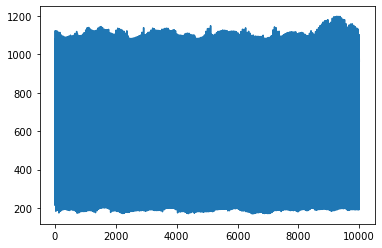

In [17]:
plt.plot(gru_outputs[0])
plt.show()

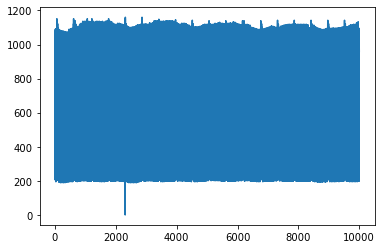

In [18]:
plt.plot(targets[0])
plt.show()

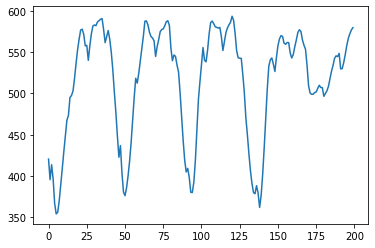

In [19]:
tp = []
for row in gru_outputs[0].reshape(-1, 50):
    tp.append(row[9])
plt.plot(tp)
plt.show()

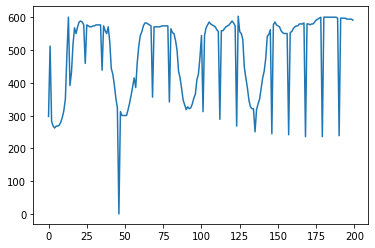

In [20]:
tp = []
for row in targets[0].reshape(-1, 50):
    tp.append(row[9])
plt.plot(tp)
plt.show()

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# h36m骨架连接顺序，每个骨架三个维度，分别为：起始关节，终止关节，左右关节标识(0 left 1 right)
connectivity_dict = [[0, 1, 0], [0, 15, 0], [0, 16, 1], [17, 15, 0], [18, 16, 1], [1, 2, 0], [2, 3, 0],
                              [3, 4, 0], [1, 5, 1], [5, 6, 1],
                              [6, 7, 1], [1, 8, 0], [8, 9, 0], [9, 10, 0], [10, 11, 0], [11, 24, 0],
                              [11, 22, 0], [22, 23, 0], [8, 12, 1], [12, 13, 1], [13, 14, 1], [14, 21, 1],
                              [14, 19, 1], [19, 20, 1]]


def draw2Dpose(pose_2d, ax, lcolor="#3498db", rcolor="#e74c3c", add_labels=False):  # blue, orange
    for i in connectivity_dict:
        x, y = [np.array([pose_2d[i[0], j], pose_2d[i[1], j]]) for j in range(2)]
        ax.plot(x, y, lw=2, c=lcolor if i[2] else rcolor)
        

In [22]:
ps = []
for p in gru_outputs[0].reshape(-1, 50):
    ps.append(np.array(p.reshape(-1,2).tolist()))

print(ps)

[array([[ 982.26855469,  214.5713501 ],
       [ 991.82910156,  333.95800781],
       [ 896.31451416,  333.05447388],
       [ 882.34533691,  449.26290894],
       [ 879.33599854,  420.58615112],
       [1086.80212402,  344.14135742],
       [1123.15136719,  458.29650879],
       [1110.05163574,  600.7989502 ],
       [ 990.94439697,  572.39733887],
       [ 938.44921875,  576.05432129],
       [ 934.1104126 ,  775.4206543 ],
       [ 943.88604736,  955.71020508],
       [1035.96630859,  565.5859375 ],
       [1083.43212891,  731.37792969],
       [1064.73791504,  895.53485107],
       [1025.01135254,  183.47555542],
       [1068.14465332,  193.76161194],
       [ 957.22064209,  222.47267151],
       [1044.83288574,  212.09025574],
       [1077.94897461,  975.31188965],
       [1096.64611816,  967.20916748],
       [1046.82043457,  888.48248291],
       [ 898.64282227,  999.48883057],
       [ 896.02349854,  988.02337646],
       [ 939.74279785,  962.55291748]]), array([[ 980.79510498,

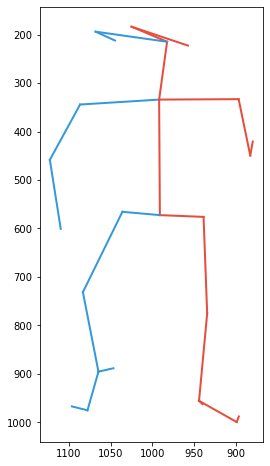

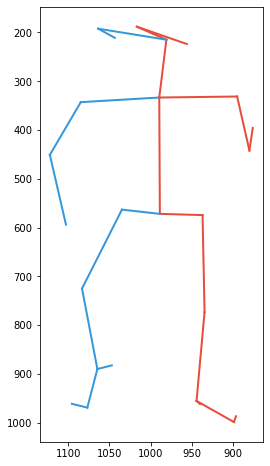

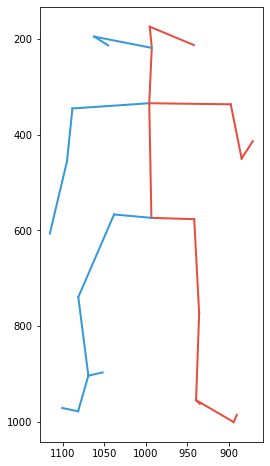

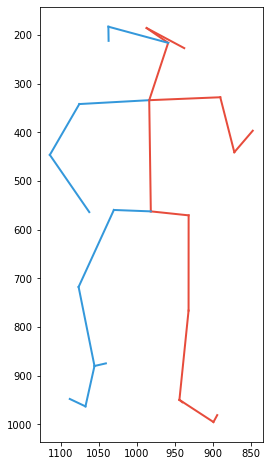

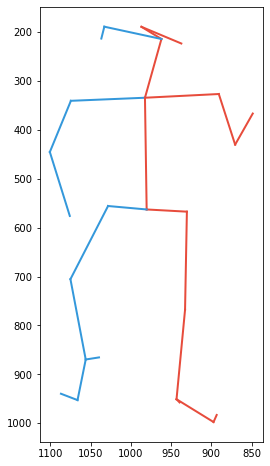

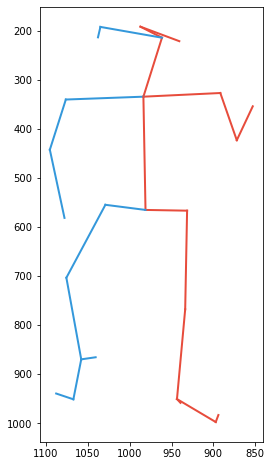

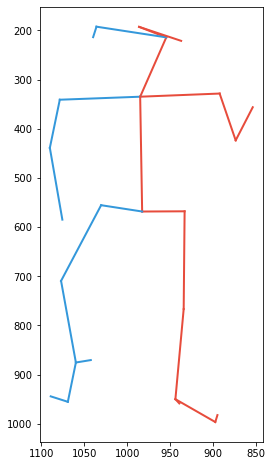

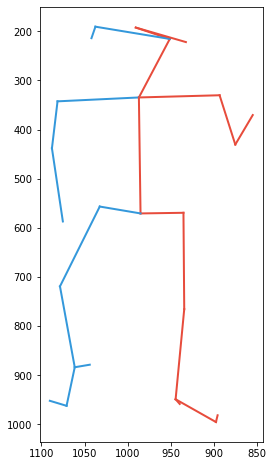

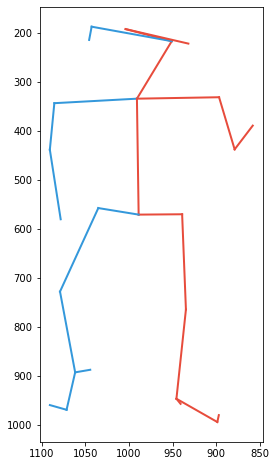

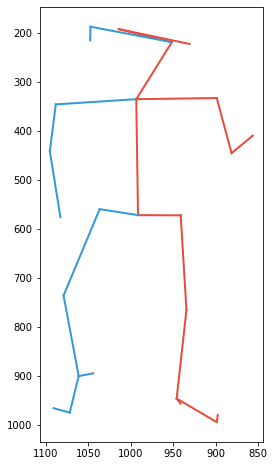

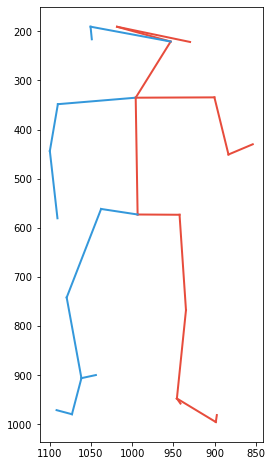

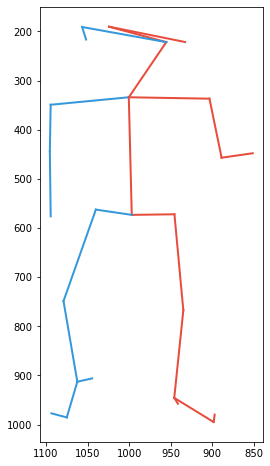

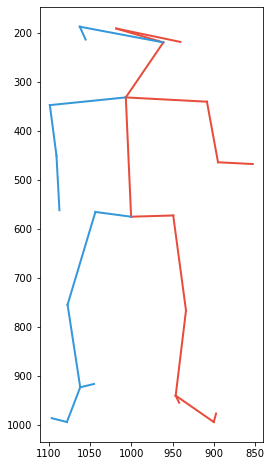

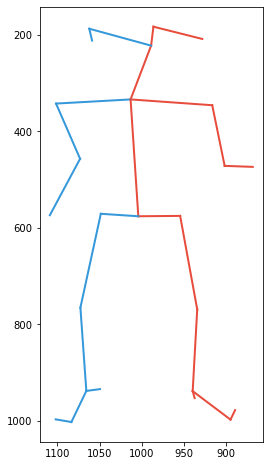

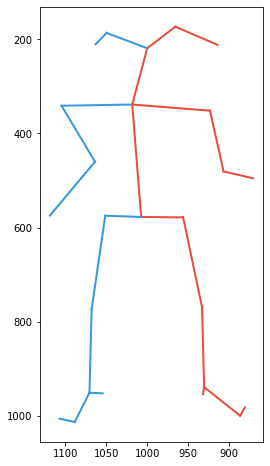

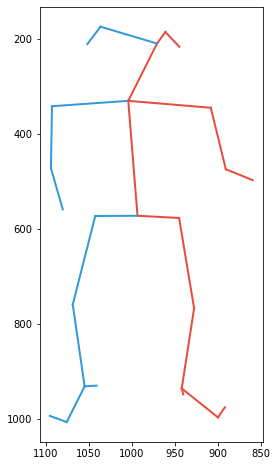

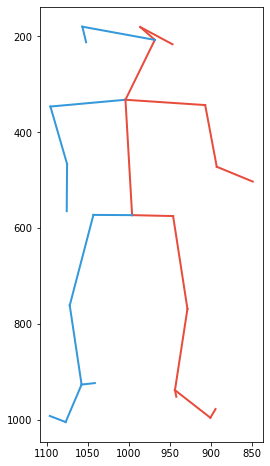

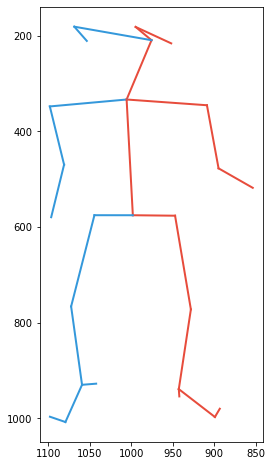

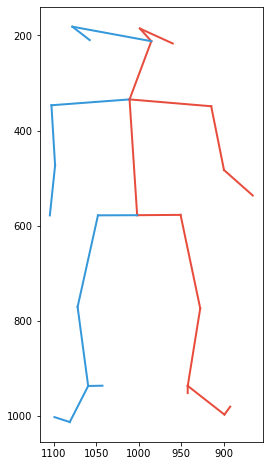

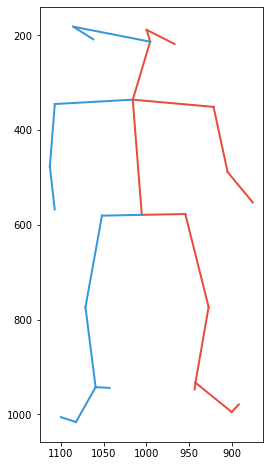

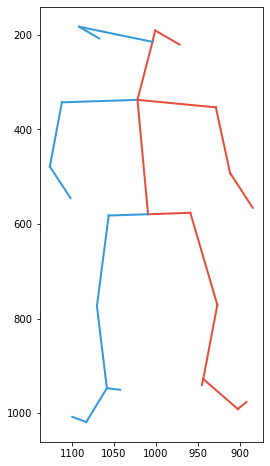

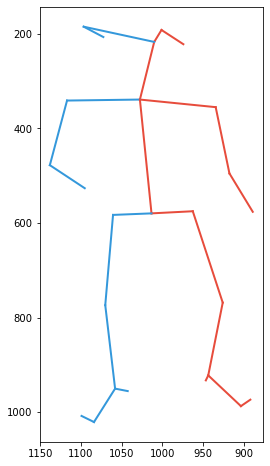

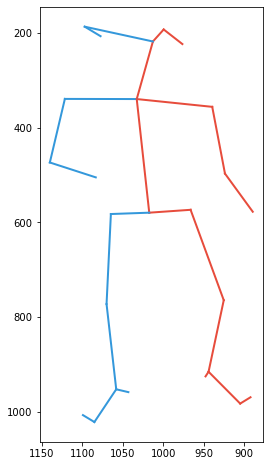

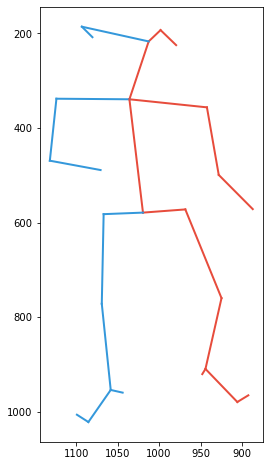

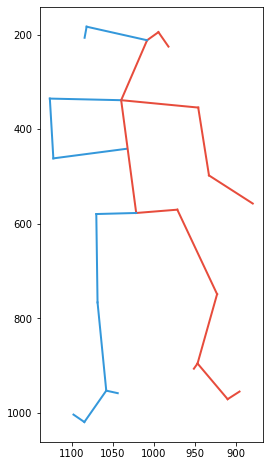

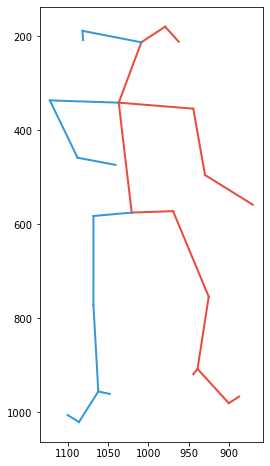

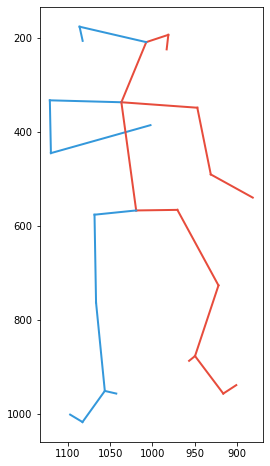

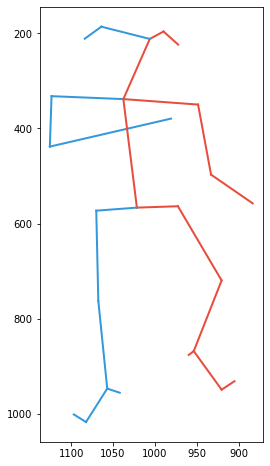

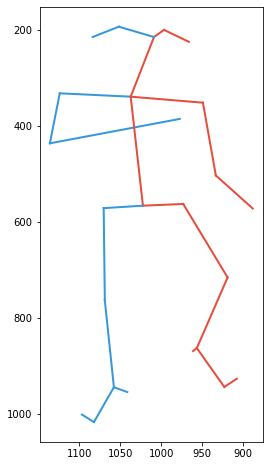

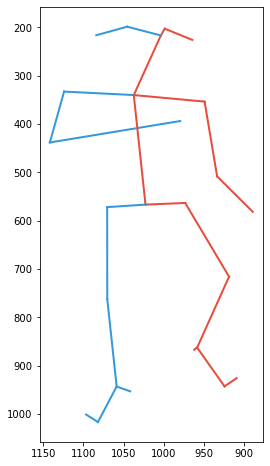

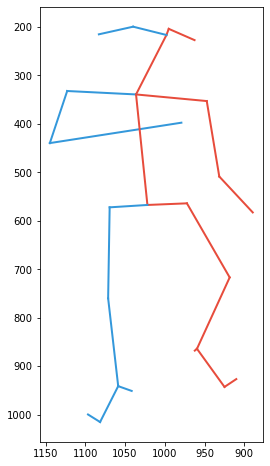

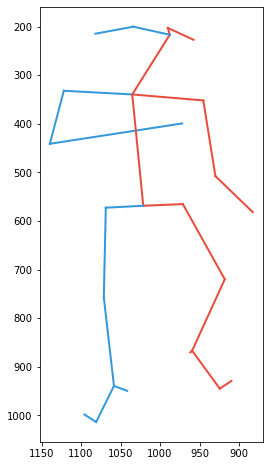

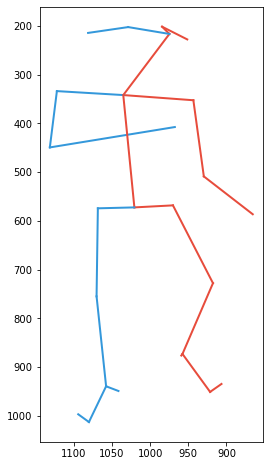

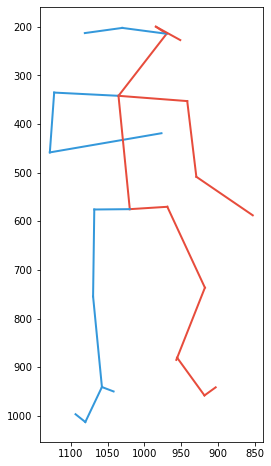

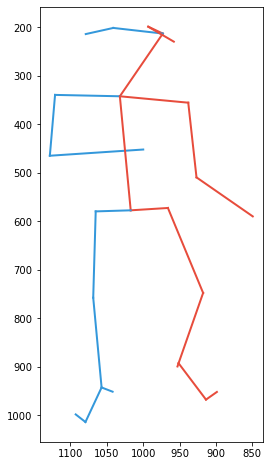

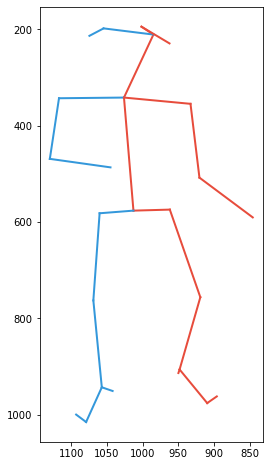

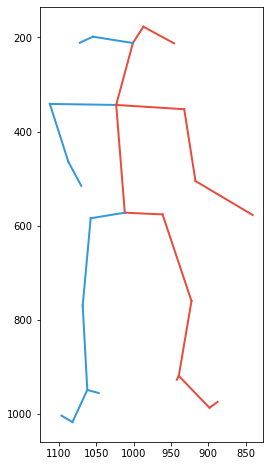

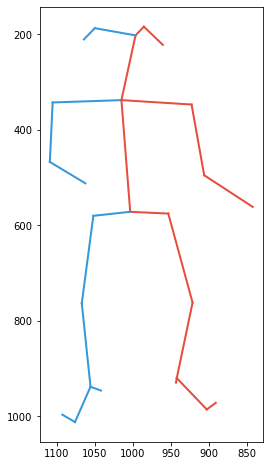

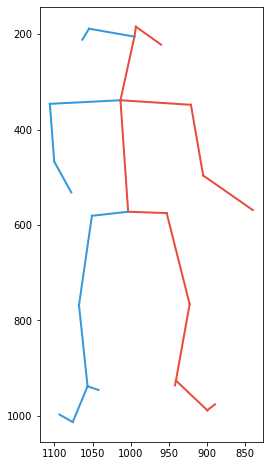

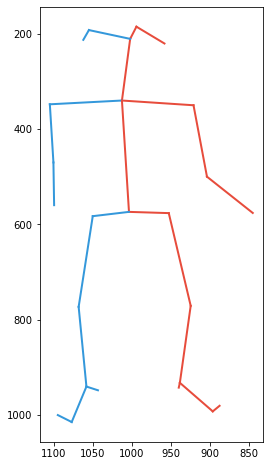

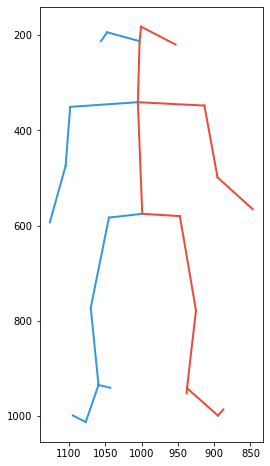

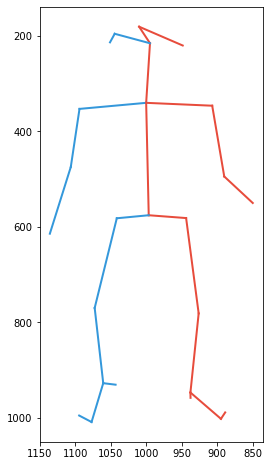

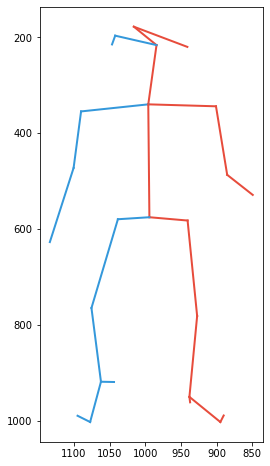

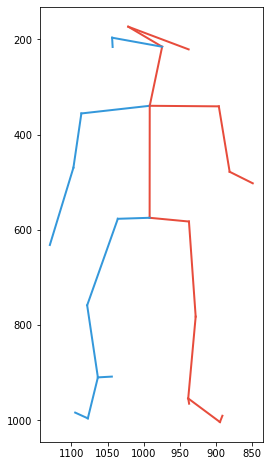

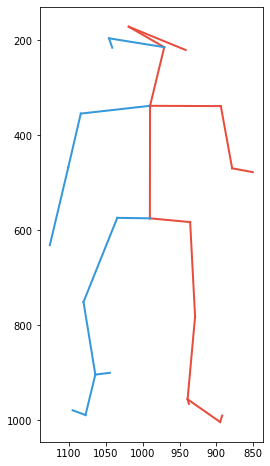

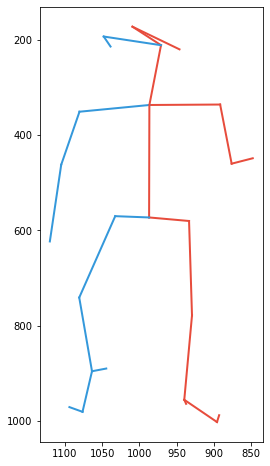

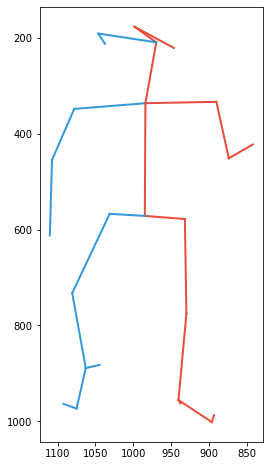

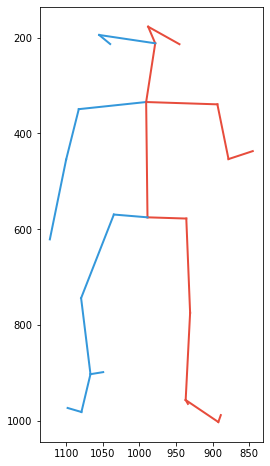

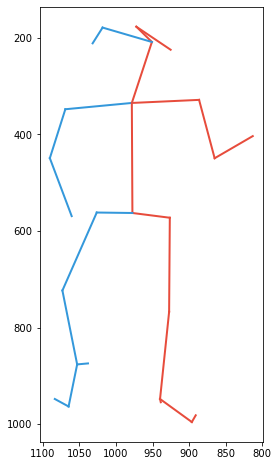

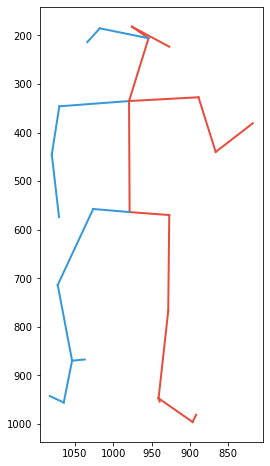

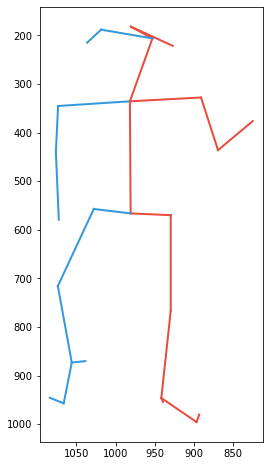

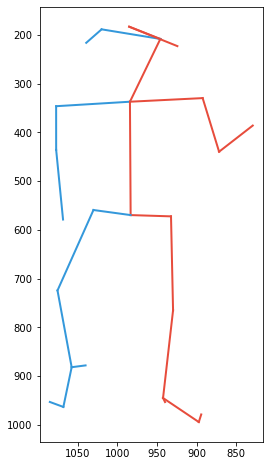

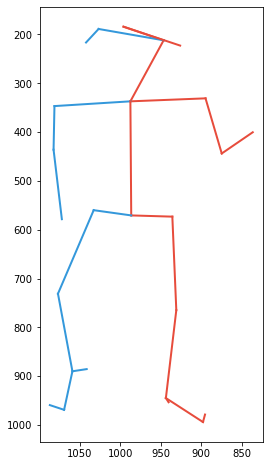

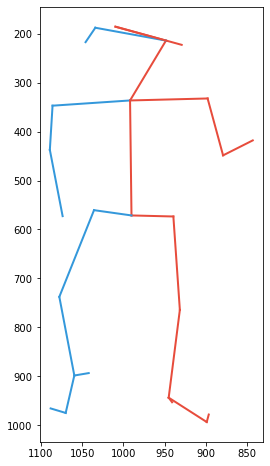

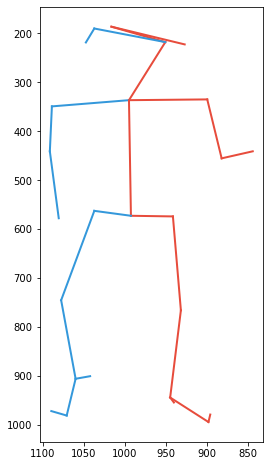

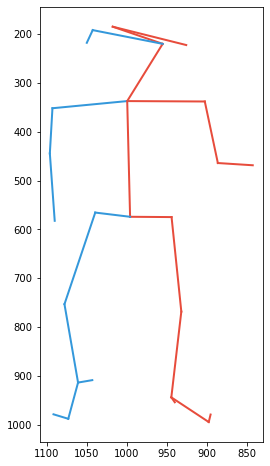

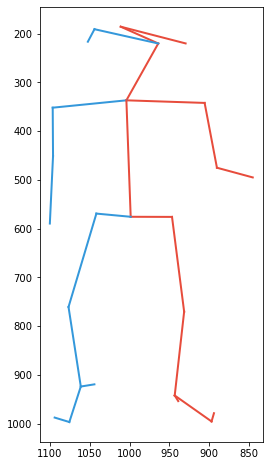

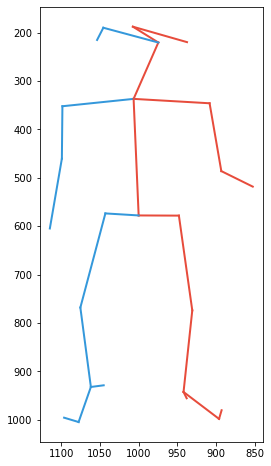

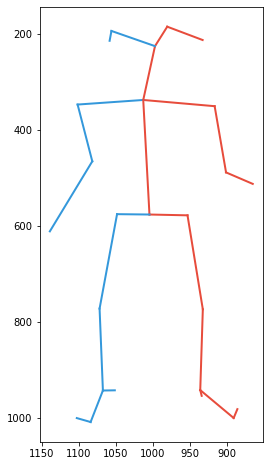

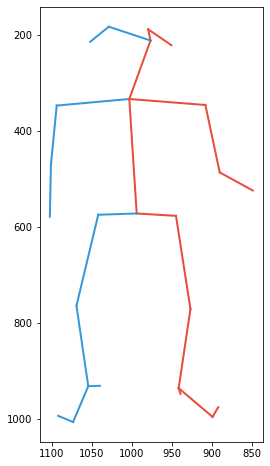

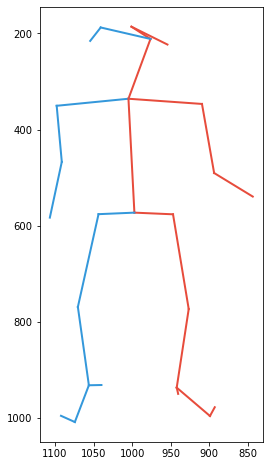

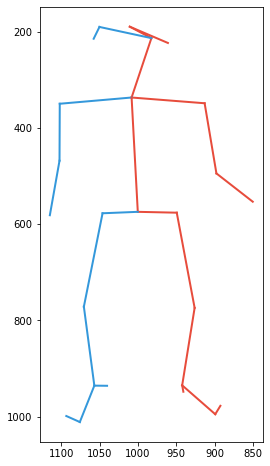

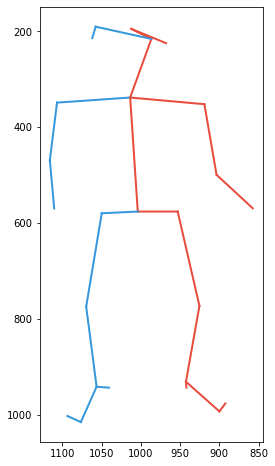

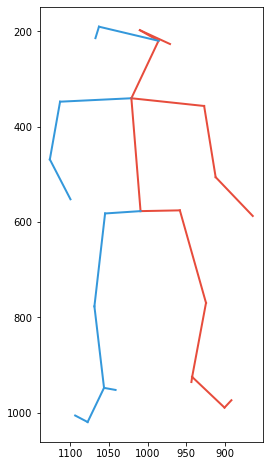

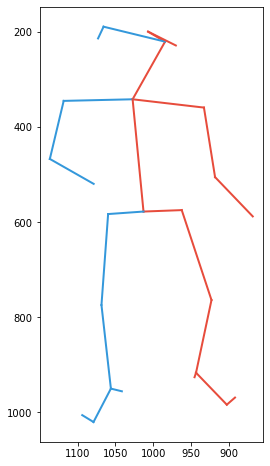

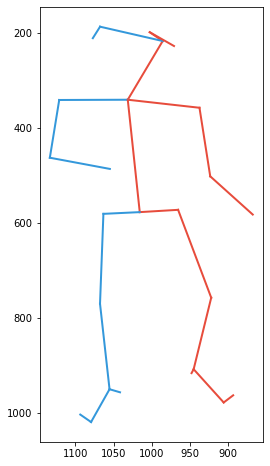

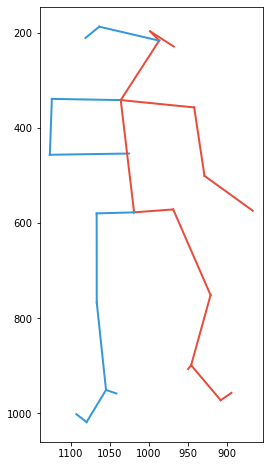

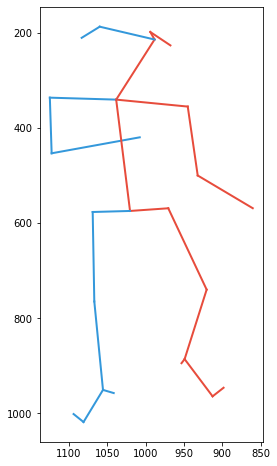

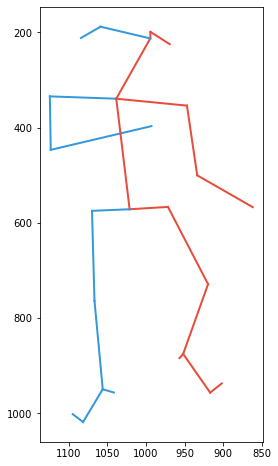

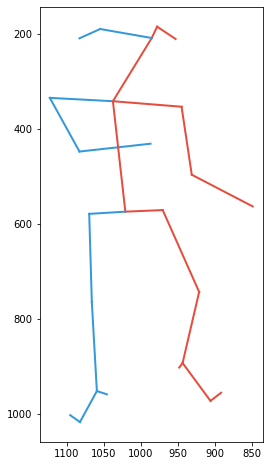

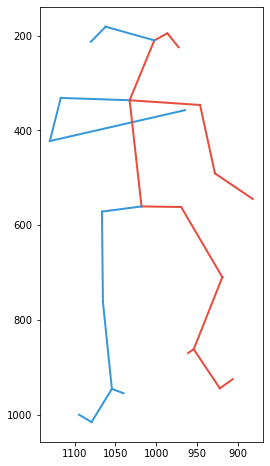

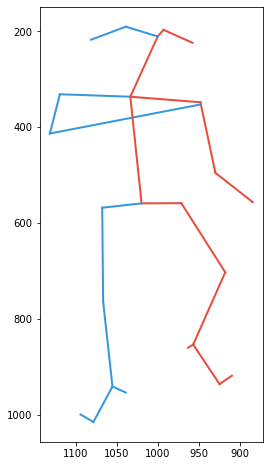

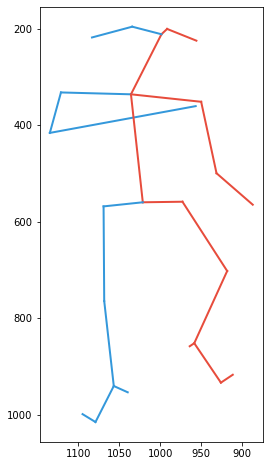

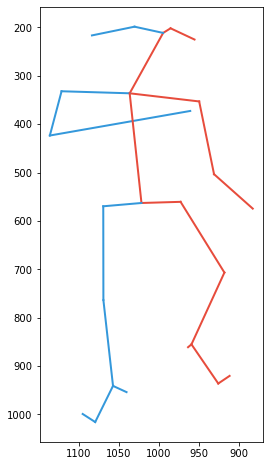

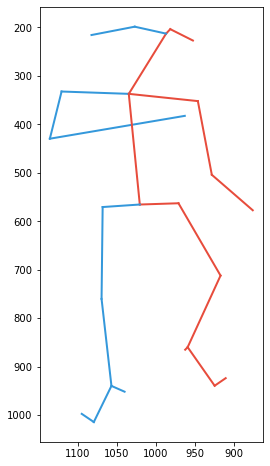

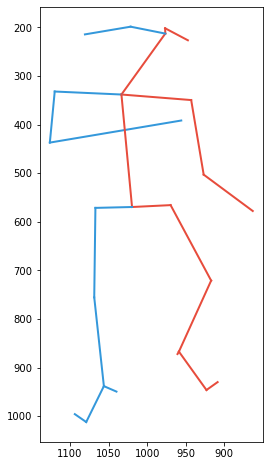

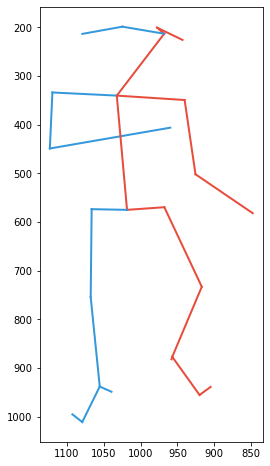

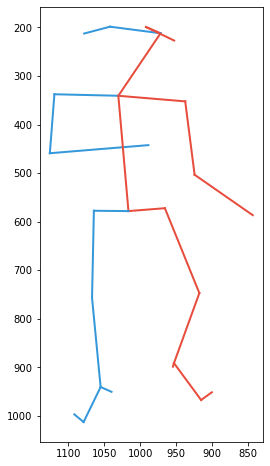

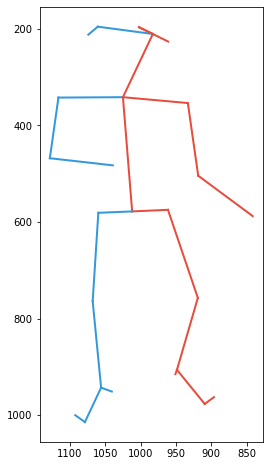

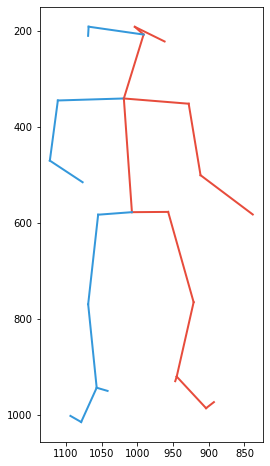

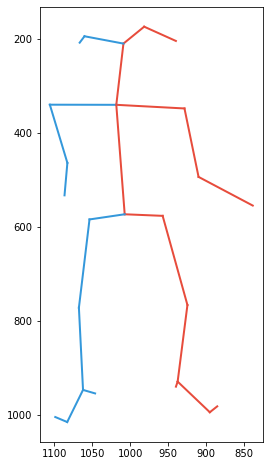

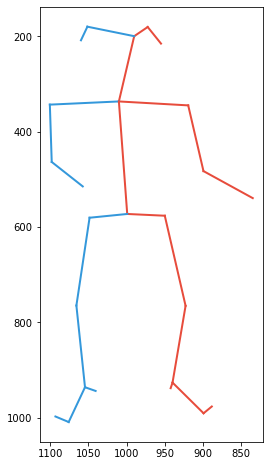

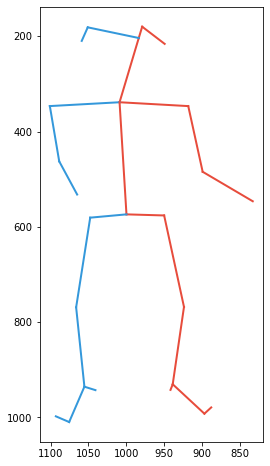

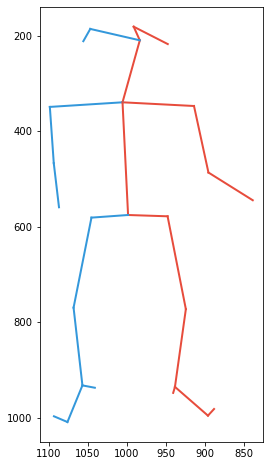

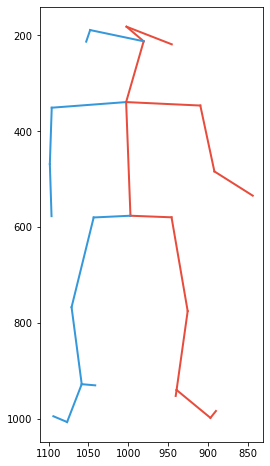

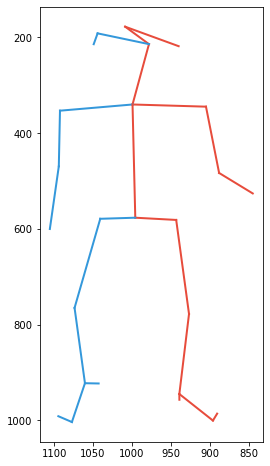

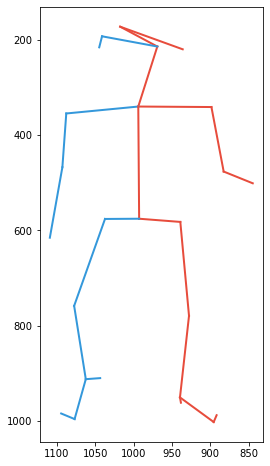

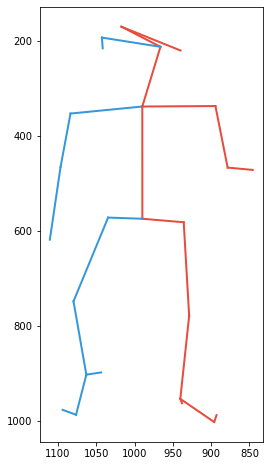

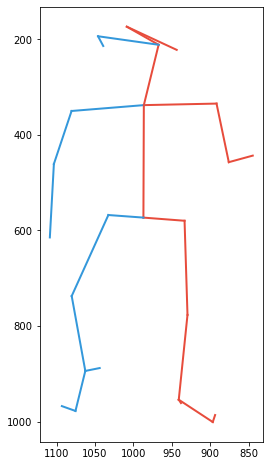

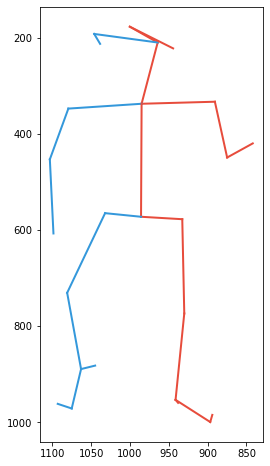

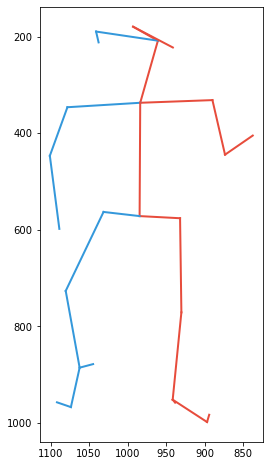

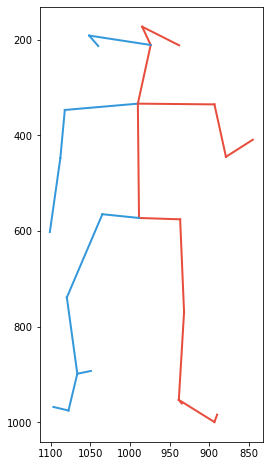

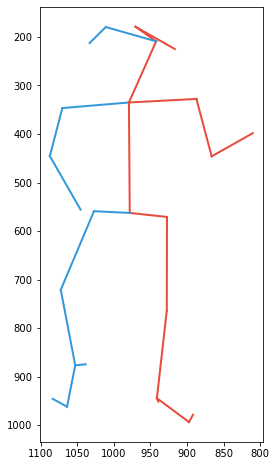

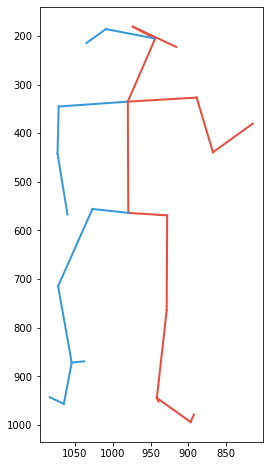

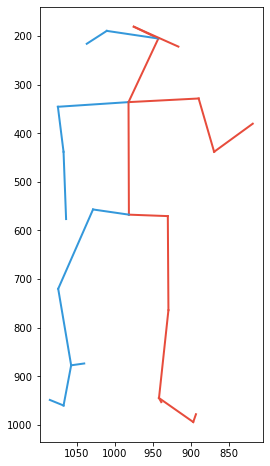

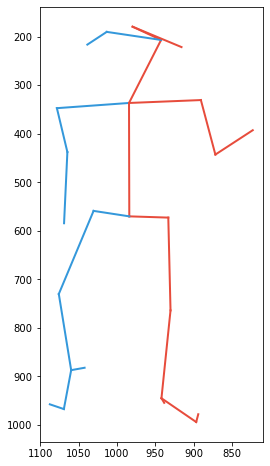

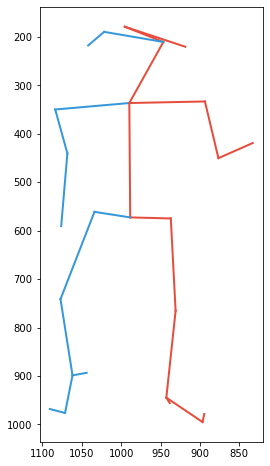

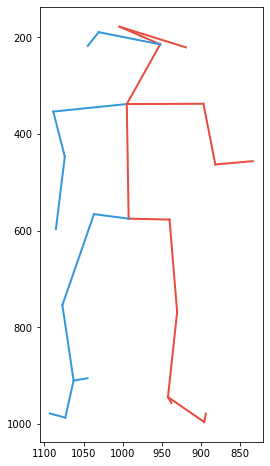

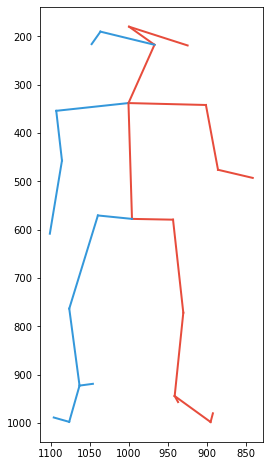

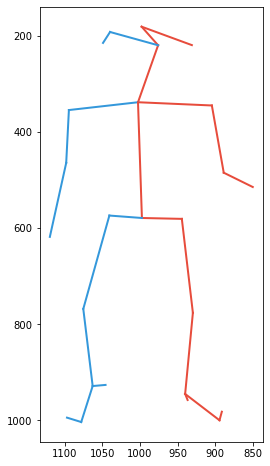

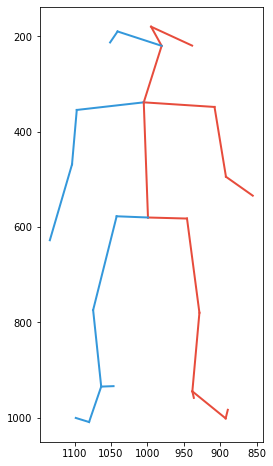

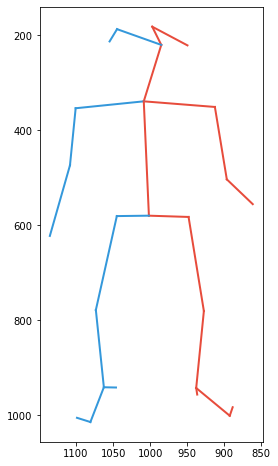

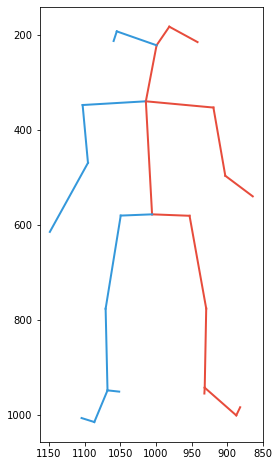

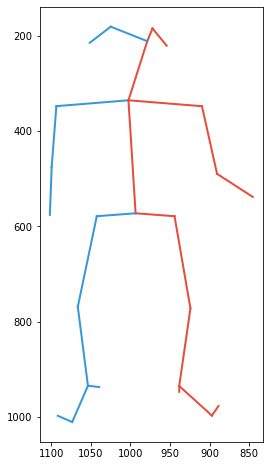

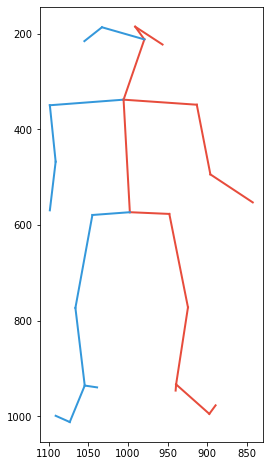

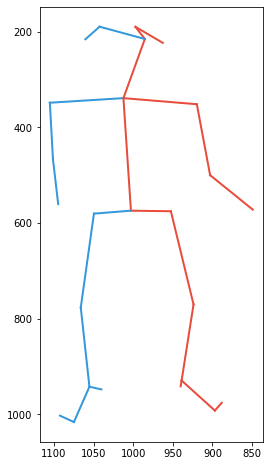

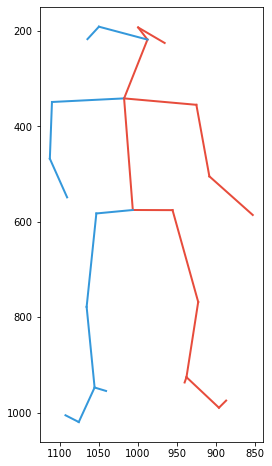

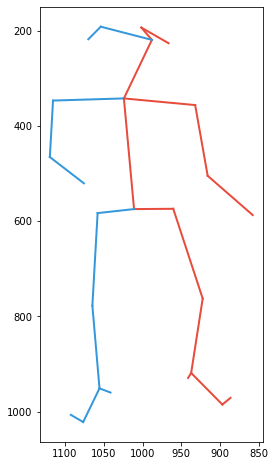

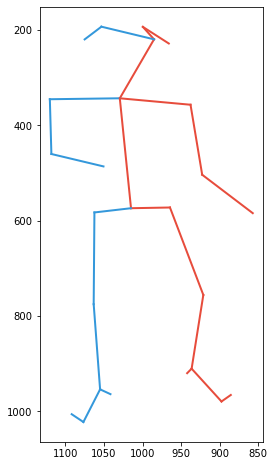

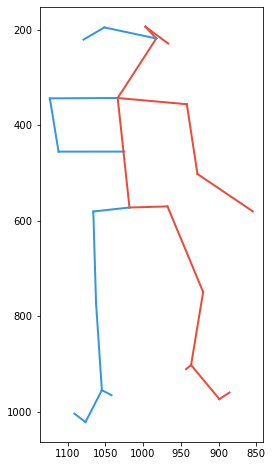

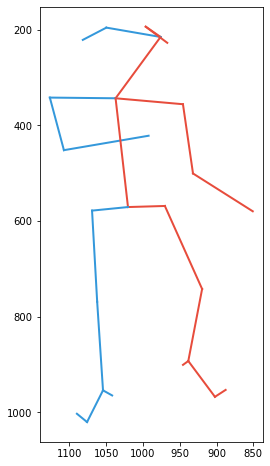

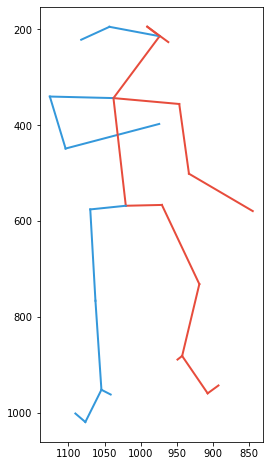

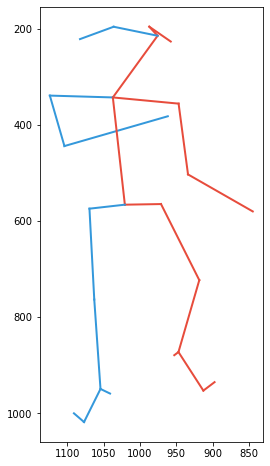

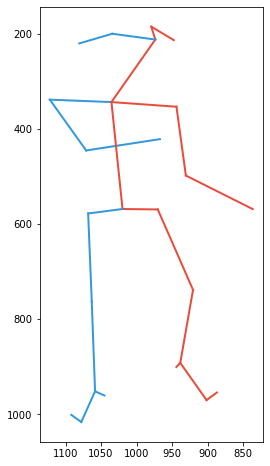

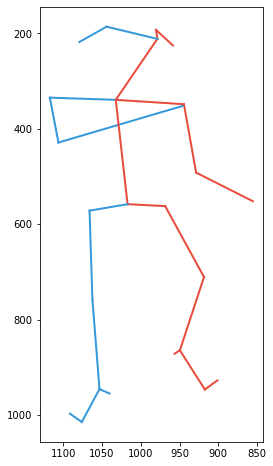

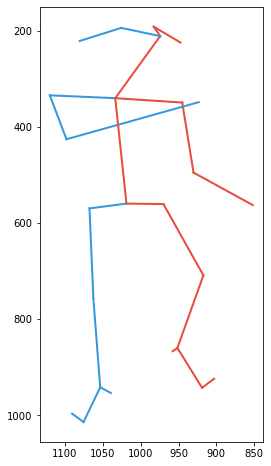

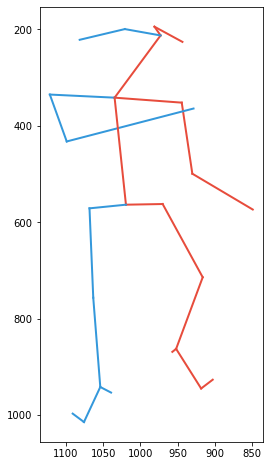

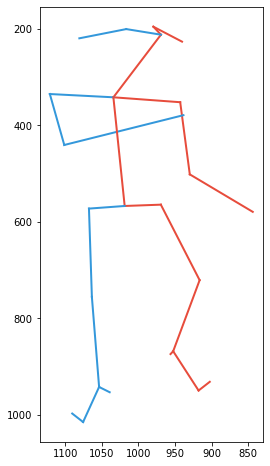

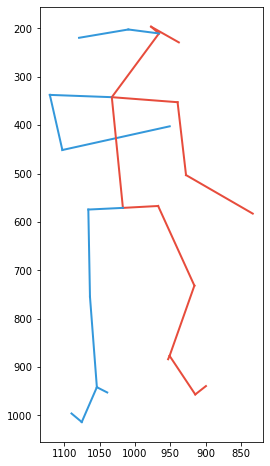

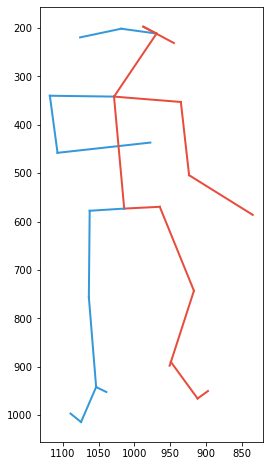

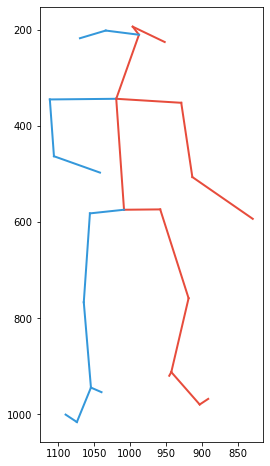

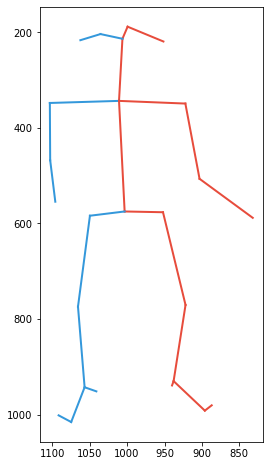

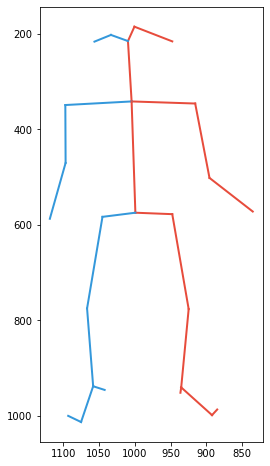

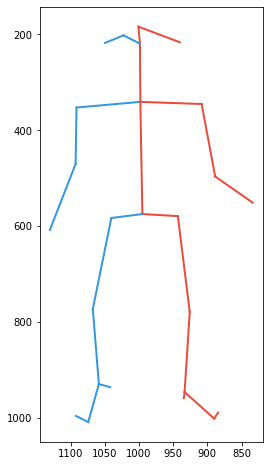

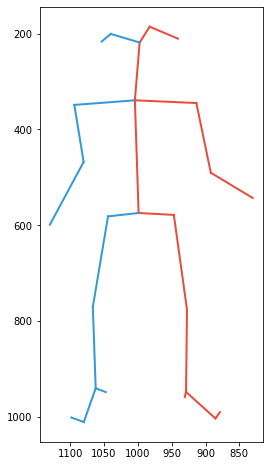

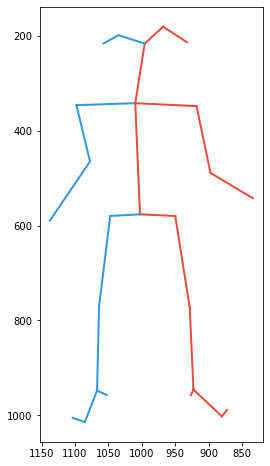

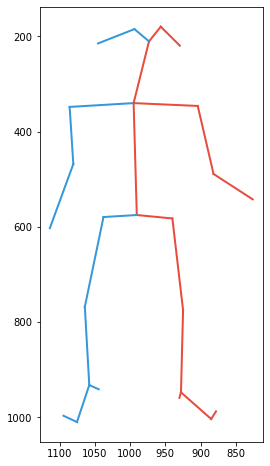

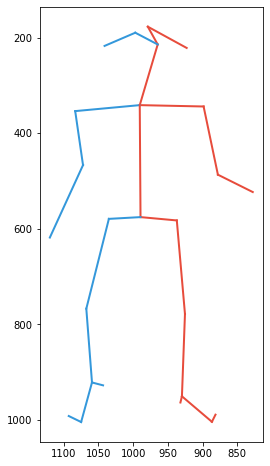

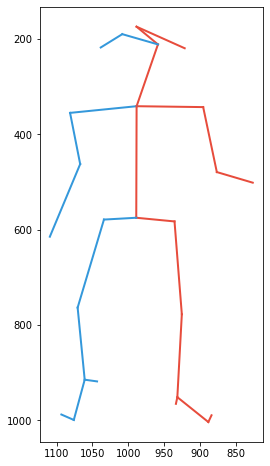

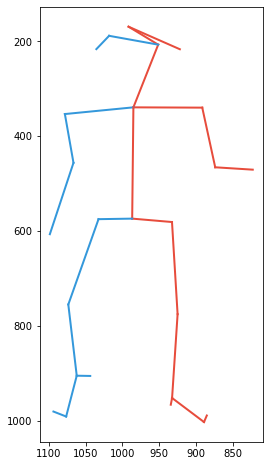

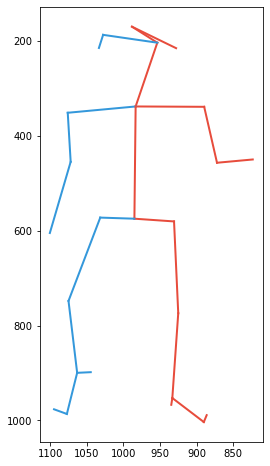

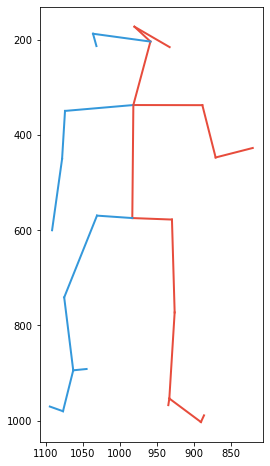

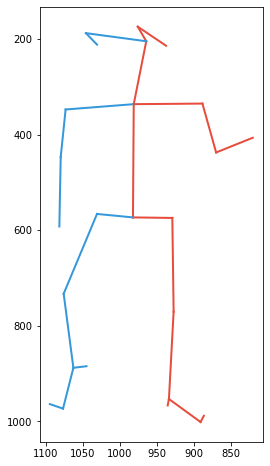

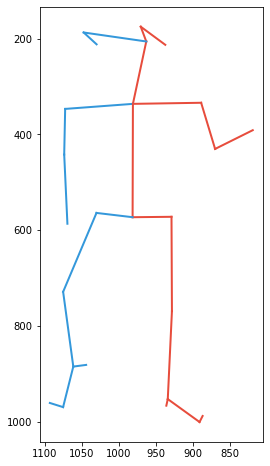

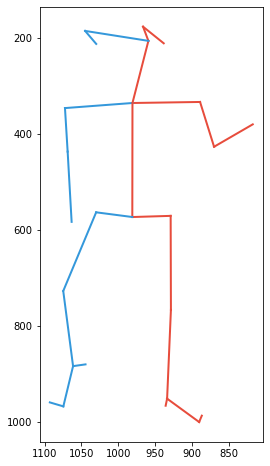

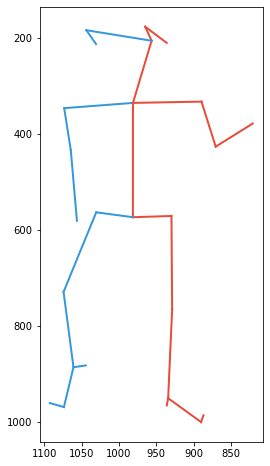

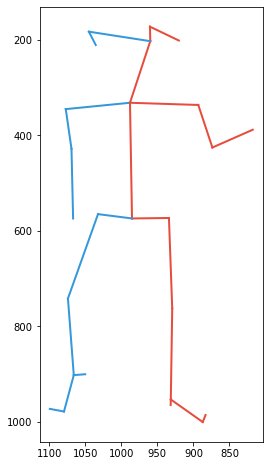

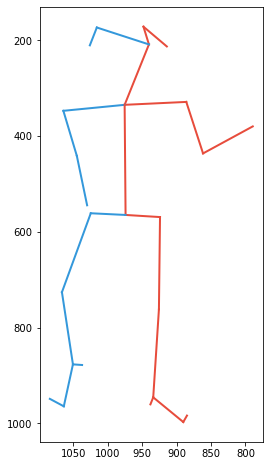

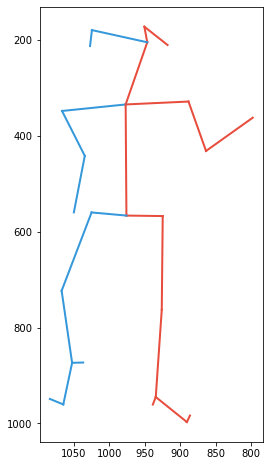

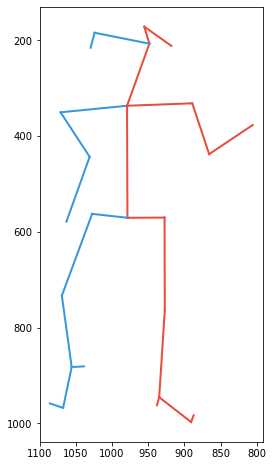

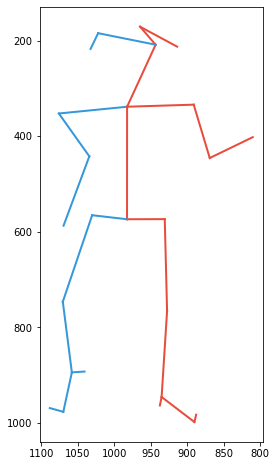

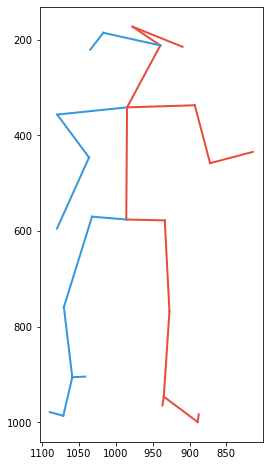

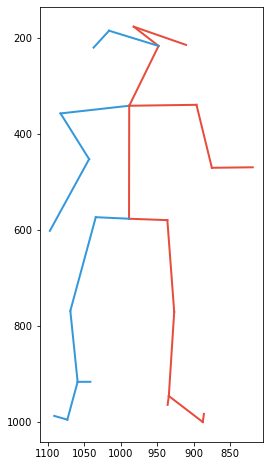

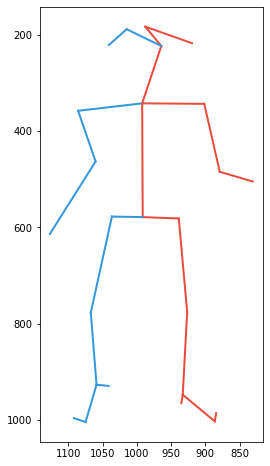

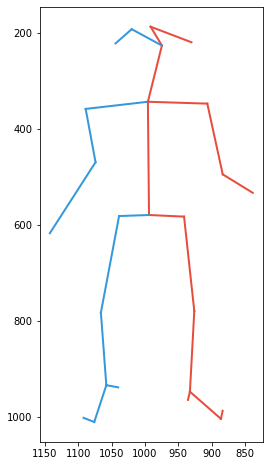

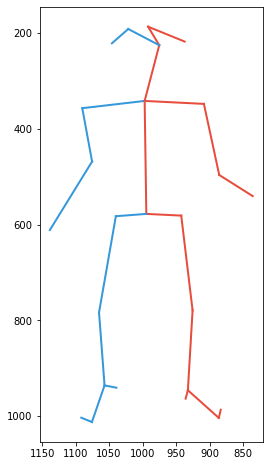

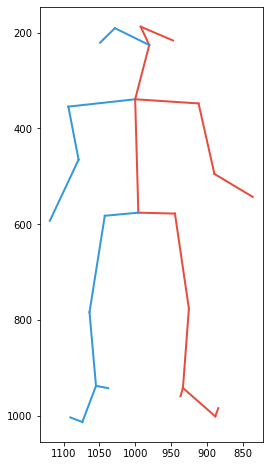

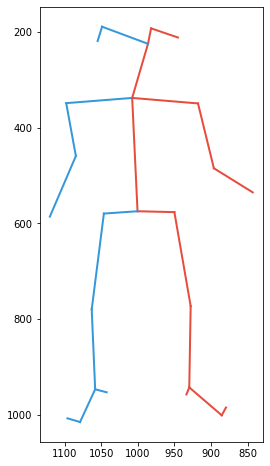

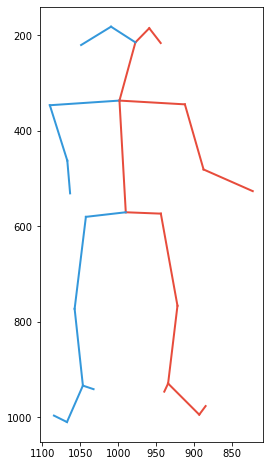

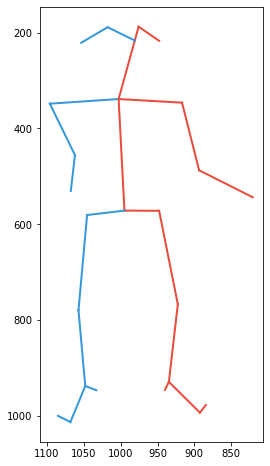

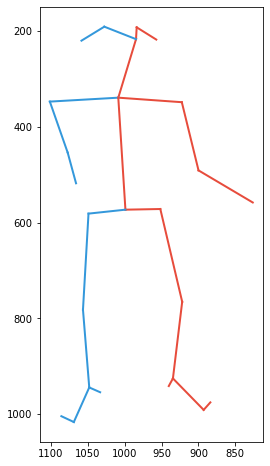

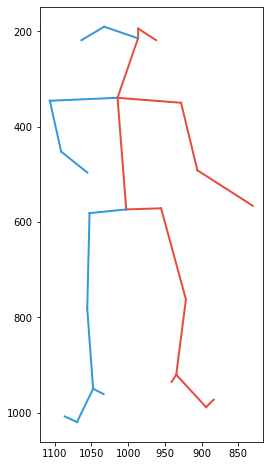

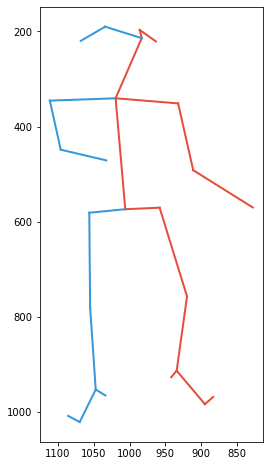

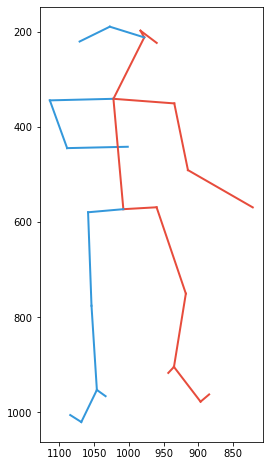

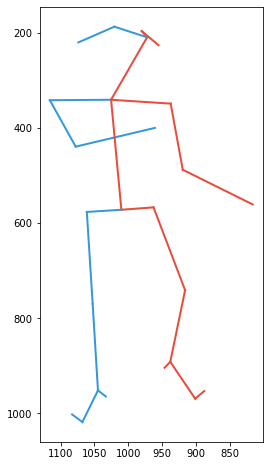

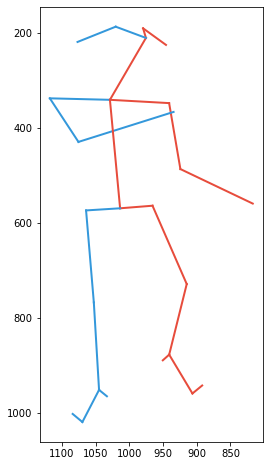

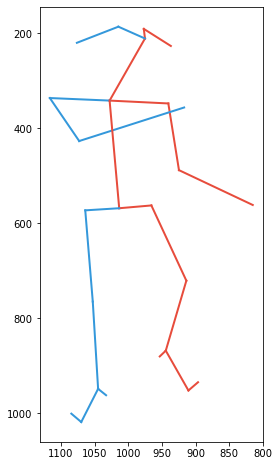

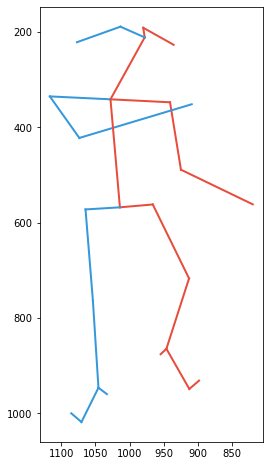

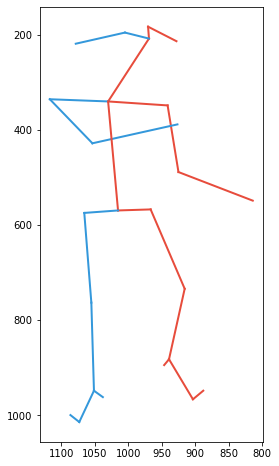

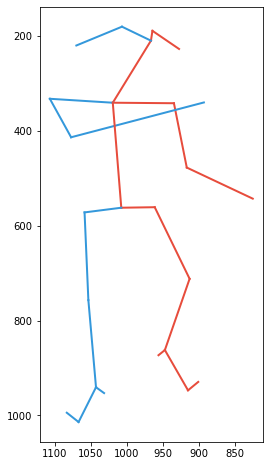

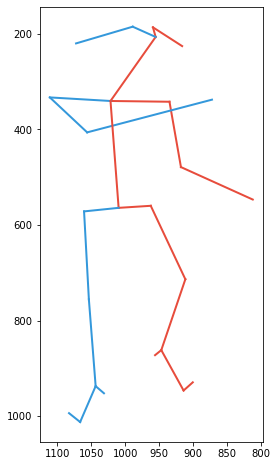

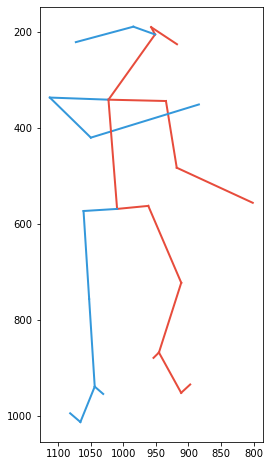

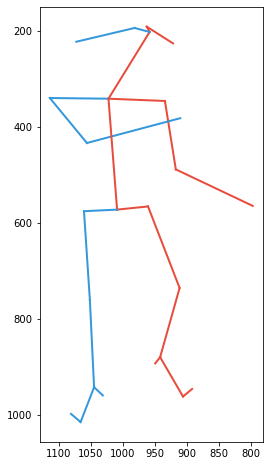

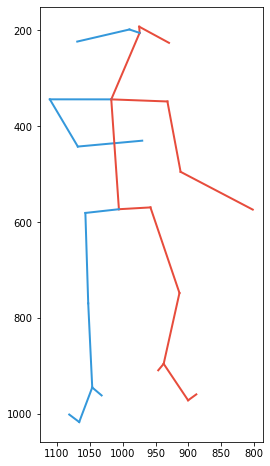

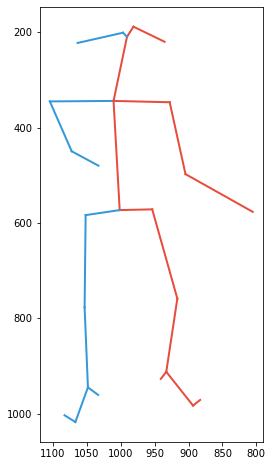

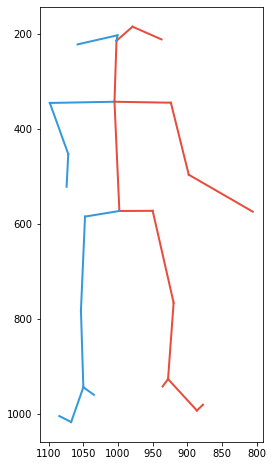

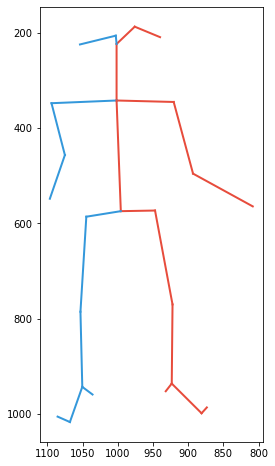

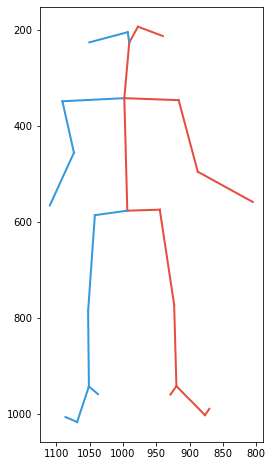

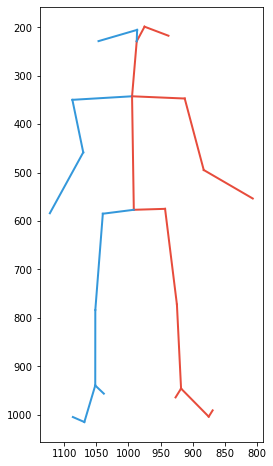

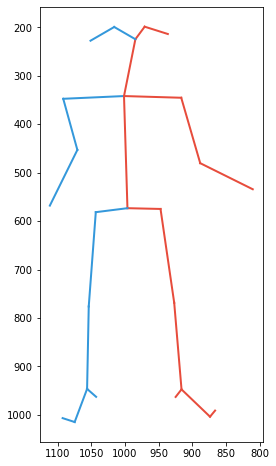

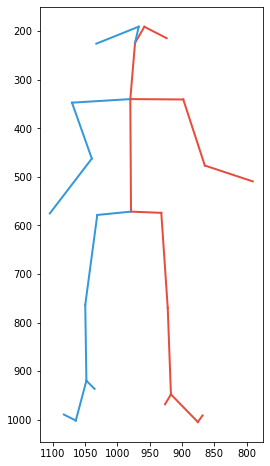

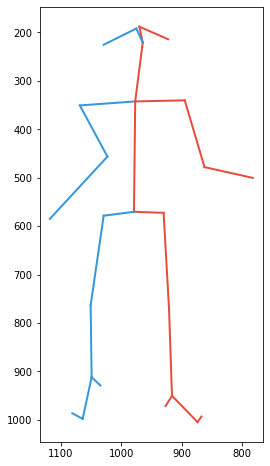

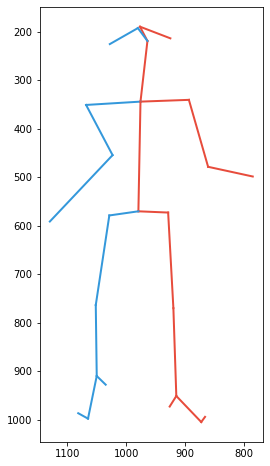

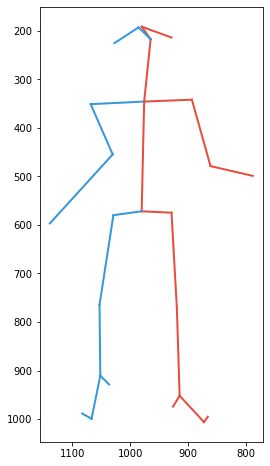

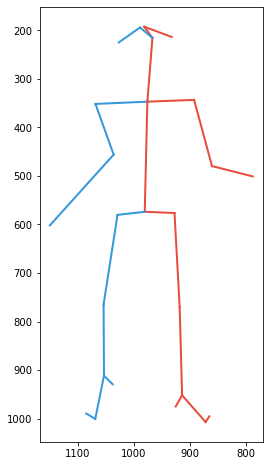

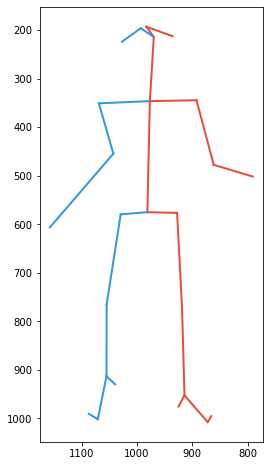

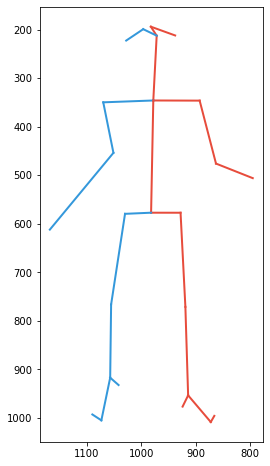

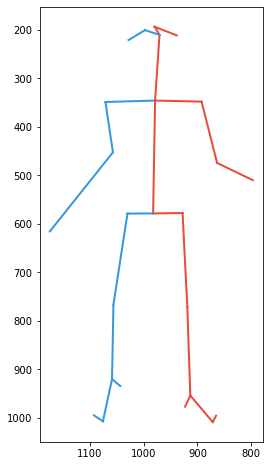

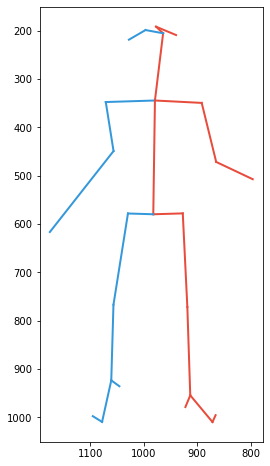

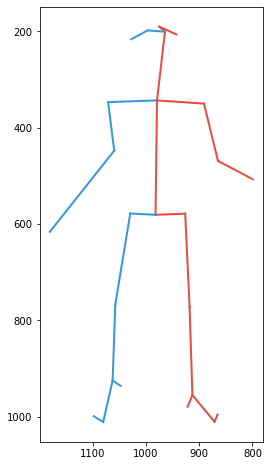

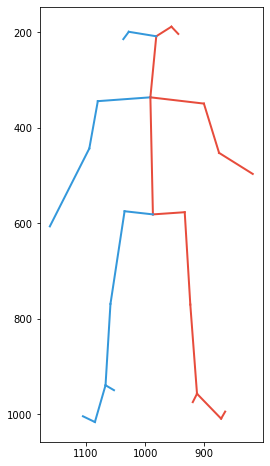

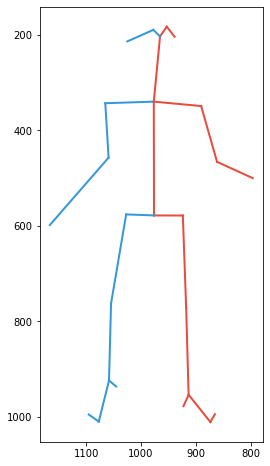

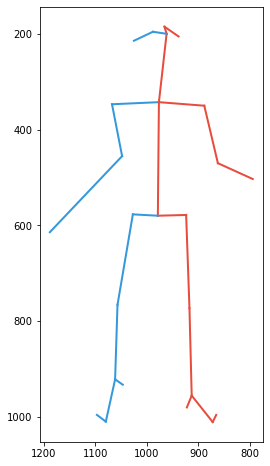

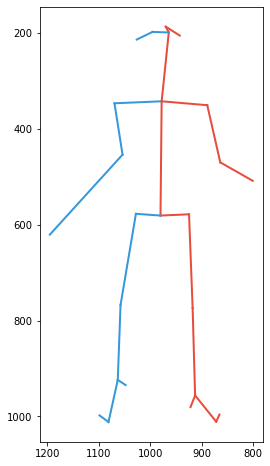

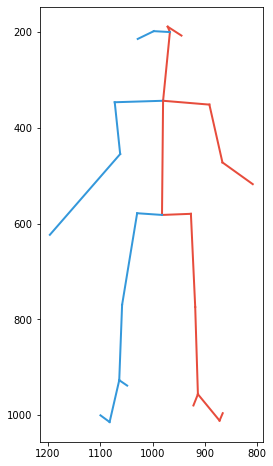

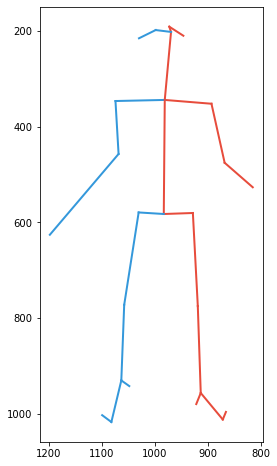

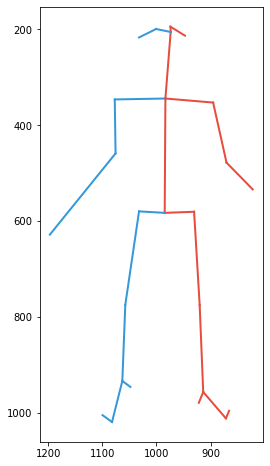

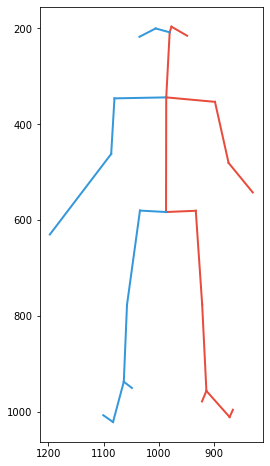

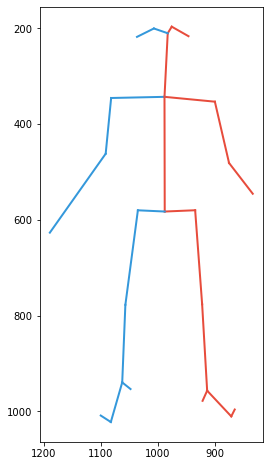

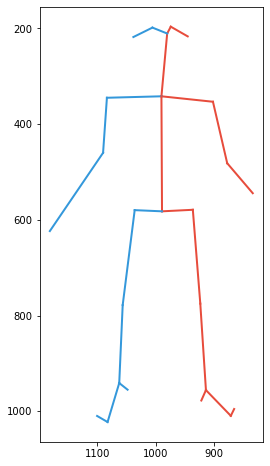

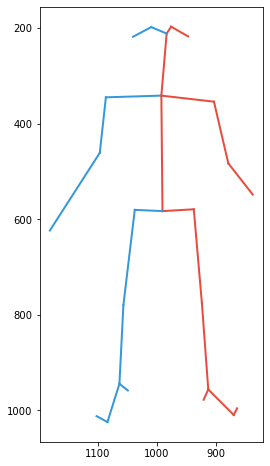

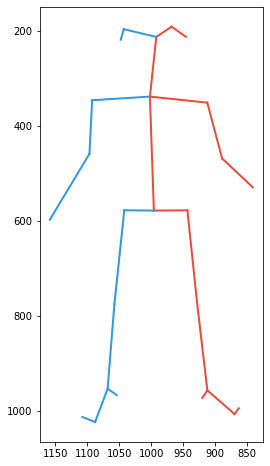

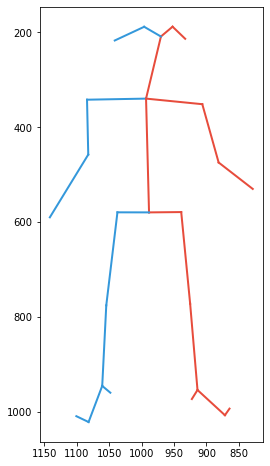

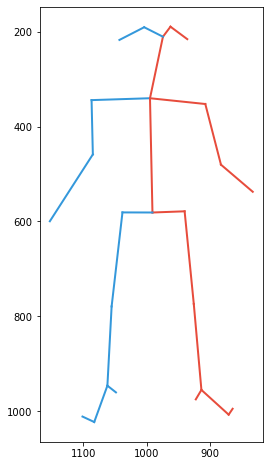

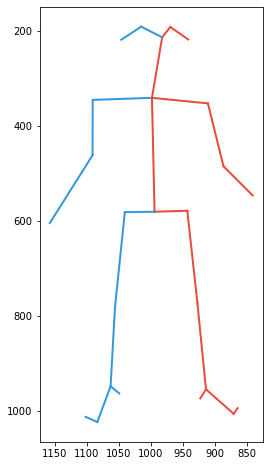

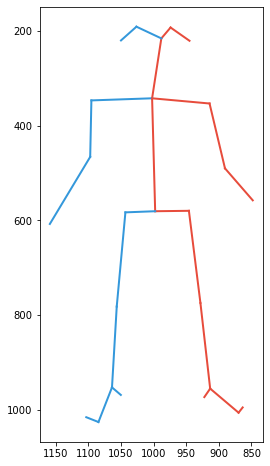

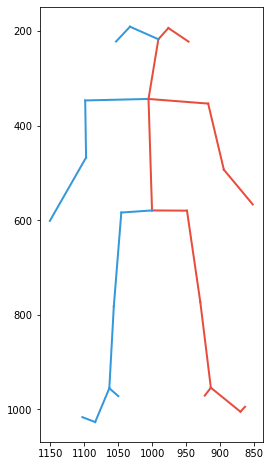

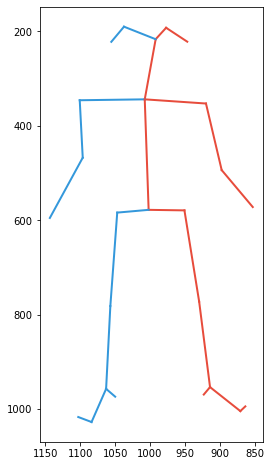

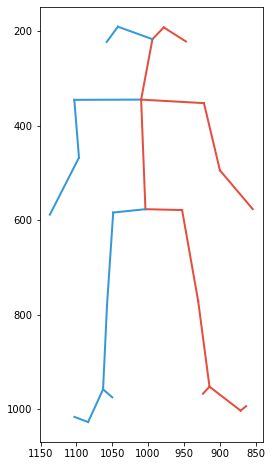

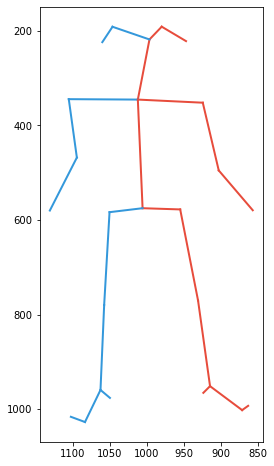

In [24]:
i = 0
for td in ps:
    fig = plt.figure(figsize=(4,8))
    ax = fig.add_subplot()
    ax.invert_xaxis()
    ax.invert_yaxis()
    draw2Dpose(td, ax)
    plt.show()
    fig.savefig('out_imgs/no_{}.png'.format(i))
    i += 1